---
title: Box-Jenkins Modeling
---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

We shall examples of Box-Jenkins modeling: dealing with nonstationarity by differencing, and then fitting **causal, stationary** ARMA models to the differenced data. 

Before that, let us first simulate data from AR models, and see how the simulated data looks differently for stationary vs non-stationary AR models. 

## Simulated Data from AR(1)

Below we simulate $n$ observations $y_1, \dots, y_n$ from the AR(1) model in a forward fashion i.e., we set $y_1 = 0$ and then generate $y_2, y_3, \dots$ recursively via $y_t = \phi_0 + \phi_1 y_{t-1} + \epsilon_t$. Observe how the data look different when $|\phi_1| < 1$ compared to $|\phi_1| > 1$. 

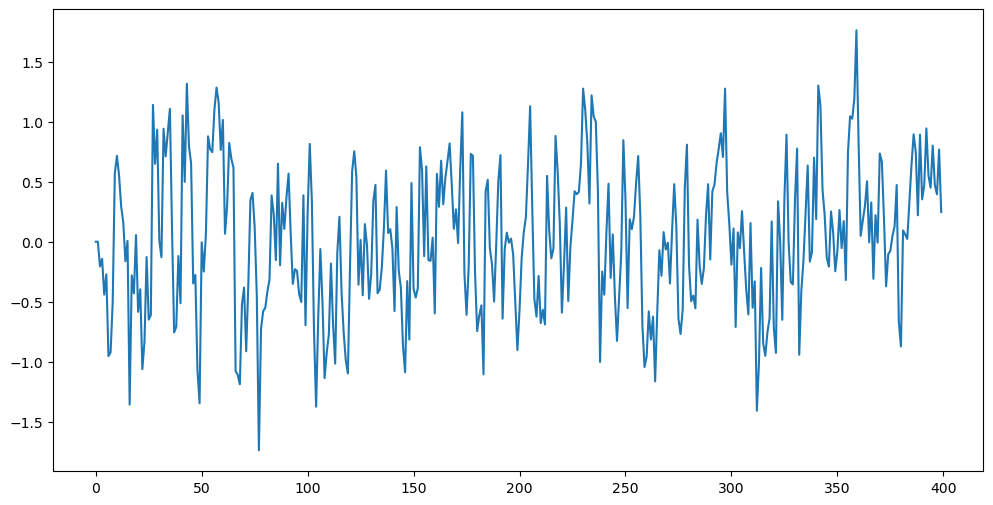

In [7]:
sig = 0.5
phi_0 = 0
phi_1 = 0.5 
#phi_1 = 2
n = 400
seed = 600
rng = np.random.default_rng(seed)
ysim = np.zeros(n) #we are initializing at zero
for t in range(2, n):
    err = rng.normal(loc = 0, scale = sig, size = 1)
    ysim[t] = phi_0 + phi_1 * ysim[t-1] + err[0]
plt.figure(figsize = (12, 6))
plt.plot(ysim)
plt.show()

Go back to above code and change $\phi_1$ to a value strictly larger than 1 say $\phi_1 = 2$, then the generate data will explode (either in the positive or negative direction). 

However, when $|\phi_1| > 1$, there will not be any explosion if we simulate the data backwards by initializing with the last entry of $y$ i.e., we set $y_n = 0$ and then generate $y_{n-1}, y_{n-2}, \dots$ by $y_{t-1} = -(\phi_0/\phi_1) + (y_t/\phi_1) - \epsilon_t/\phi_1$ for $t = n, n-1, \dots$. This is shown below. This backward simulation will explode if $|\phi_1| < 1$. 

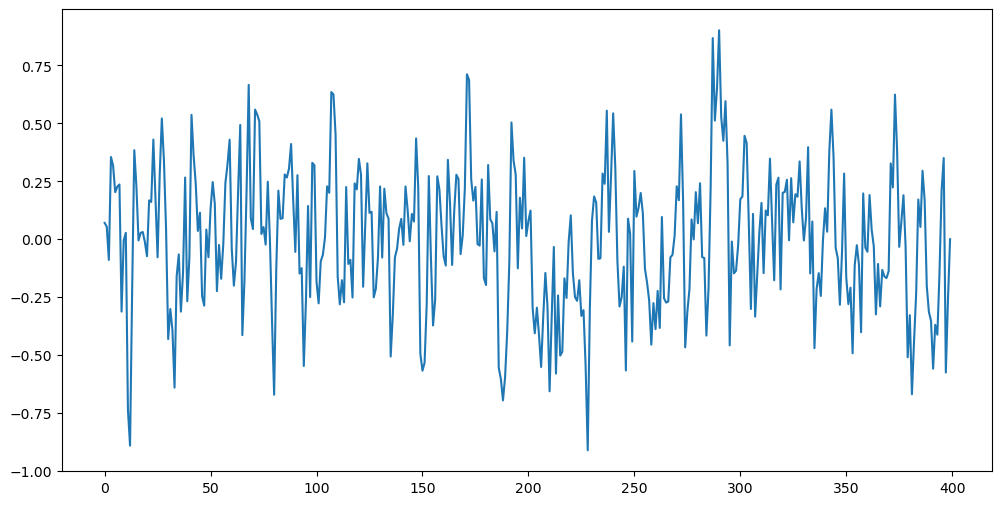

In [11]:
#backward simulation
sig = 0.5
phi_0 = 0
phi_1 = 2
n = 400
seed = 6
rng = np.random.default_rng(seed)
ysim = np.zeros(n) #we are initializing at zero
for t in range(n-1, 0, -1):
    err = rng.normal(loc = 0, scale = sig, size = 1)
    ysim[t-1] = (ysim[t]/phi_1) - (phi_0/phi_1) - err[0]/phi_1
plt.figure(figsize = (12, 6))
plt.plot(ysim)
plt.show()

When $\phi_1 = 1$, the process is non-stationary. We can easily tell this by looking at the data (irrespective of whether the data is generated moving forward in time or backward). Go back to the code above and change $\phi_1 = 1$. How does the data look when $\phi_1 = -1$?

While working with AR(1) models, the Box-Jenkins approach only considers $\phi_1 \in (-1, 1]$. In this range, $\phi_1 \in (-1, 1)$ corresponds to stationarity and $\phi_1 = 1$ corresponds to nonstationarity. 

## AR(2)

Below we simulate data from AR(2) by forward simulation (initialize as $y_1 = 0, y_2 = 0$ and then simulate $y_3, y_4, \dots$ in sequence). We first write down $a_1, a_2$ and then take $\phi_1 = a_1 + a_2$ and $\phi_2 = -a_1 a_2$. Remember that $a_1$ and $a_2$ are the reciprocals of the roots of the characteristic polynomial $1 - \phi_1 z - \phi_2 z^2$. The causal stationary regime corresponds to $|a_1|, |a_2| < 1$. 

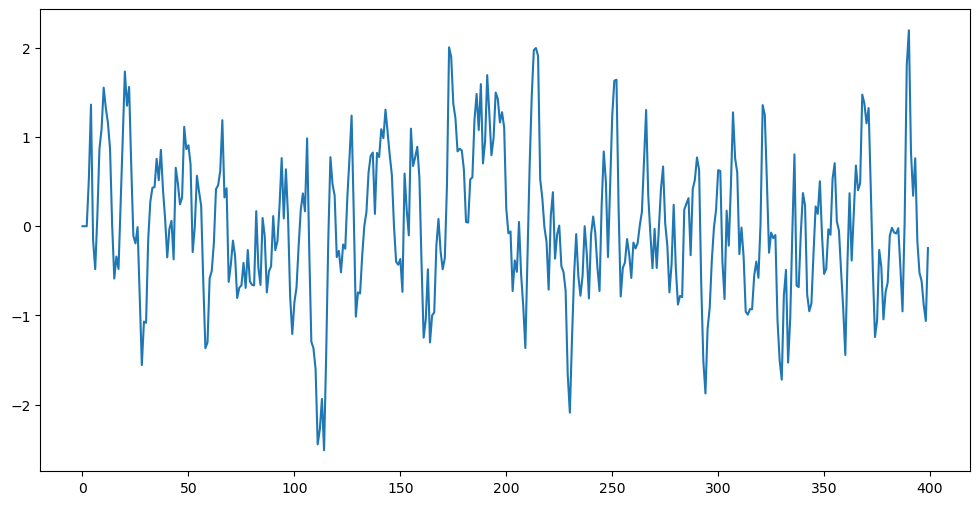

In [246]:
sig = 0.5
phi_0 = 0
a_1 = 0.4 
a_2 = .5
phi_1 = a_1 + a_2
phi_2 = -(a_1 * a_2)
n = 400
seed = 6
rng = np.random.default_rng(seed)
ysim = np.zeros(n) #we are initializing at zero
for t in range(3, n):
    err = rng.normal(loc = 0, scale = sig, size = 1)
    ysim[t] = phi_0 + phi_1 * ysim[t-1] + phi_2 * ysim[t-2]  + err[0]
plt.figure(figsize = (12, 6))
plt.plot(ysim)
plt.show()

Below we consider a situation where the roots of the AR polynomial are complex. 

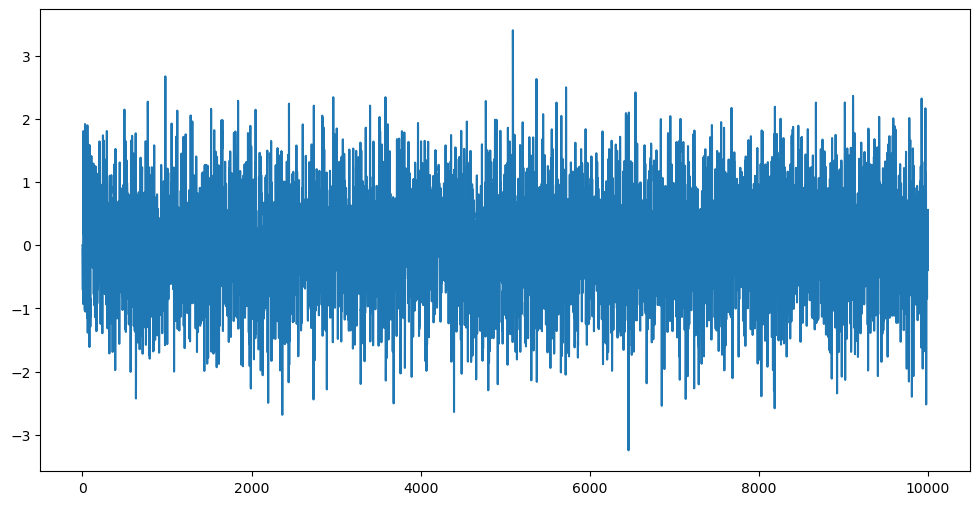

In [12]:
sig = 0.5
phi_0 = 0
a_1 = (1 + 1j)/np.sqrt(4) #if we change sqrt(4) to sqrt(2), then the roots have modulus one which corresponds to non-stationarity (compare how the simulated data look for stationarity vs nonstationarity)
a_2 = (1 - 1j)/np.sqrt(4)
phi_1 = np.real(a_1 + a_2)
phi_2 = np.real(-(a_1 * a_2))
n = 10000
seed = 60
rng = np.random.default_rng(seed)
ysim = np.zeros(n) #we are initializing at zero
for t in range(3, n):
    err = rng.normal(loc = 0, scale = sig, size = 1)
    ysim[t] = phi_0 + phi_1 * ysim[t-1] + phi_2 * ysim[t-2]  + err[0]
plt.figure(figsize = (12, 6))
plt.plot(ysim)
plt.show()



When we fit the AR($p$) model using AutoReg, the summary outputs the roots of the AR polynomial and their moduli. The modulus of the roots allow us to assess whether the fitted AR model is stationary or not. 

In [250]:
p = 2
armod = AutoReg(ysim, lags = p).fit()
print(armod.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                10000
Model:                     AutoReg(2)   Log Likelihood               -7196.610
Method:               Conditional MLE   S.D. of innovations              0.497
Date:                Tue, 15 Apr 2025   AIC                          14401.219
Time:                        16:29:31   BIC                          14430.060
Sample:                             2   HQIC                         14410.982
                                10000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.005     -0.304      0.761      -0.011       0.008
y.L1           1.0101      0.009    117.247      0.000       0.993       1.027
y.L2          -0.5080      0.009    -58.964      0.0

## ARIMA Modeling

We apply the Box-Jenkins philosophy to a real dataset from FRED. The Box-Jenkins philosophy deals with nonstationarity by differencing, and then attempts to fit a **causal, stationary** AR models  to the  differenced data.  

### TTLCONS data

The following data gives the total construction spending in the United States. 

  observation_date  TTLCONS
0       1993-01-01   458080
1       1993-02-01   462967
2       1993-03-01   458399
3       1993-04-01   469425
4       1993-05-01   468998
386


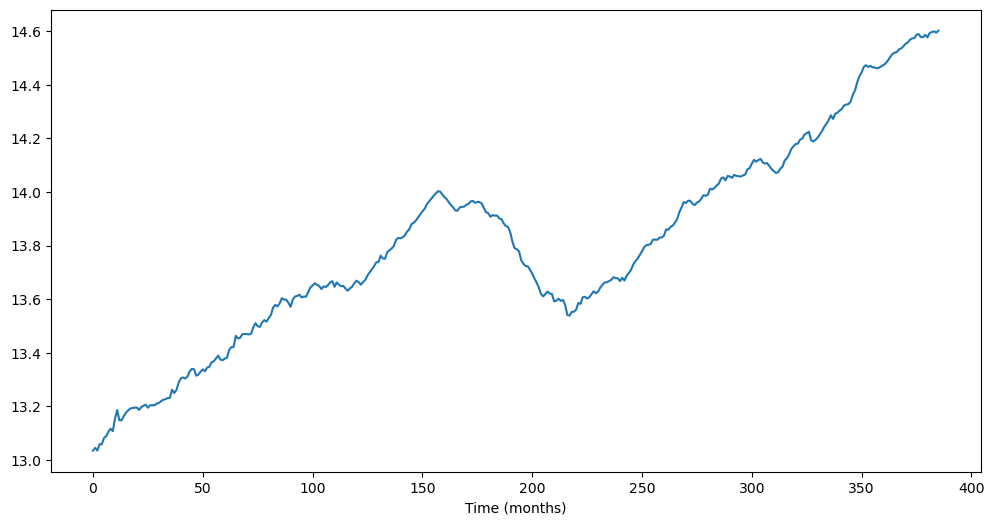

In [13]:
ttlcons = pd.read_csv('TTLCONS_14April2025.csv')
print(ttlcons.head())
y = np.log(ttlcons['TTLCONS'])
print(len(y))
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.xlabel('Time (months)')
plt.show()


It will clearly be not appropriate to fit a causal stationary model to this dataset. So we first difference and visualize the differenced data. 

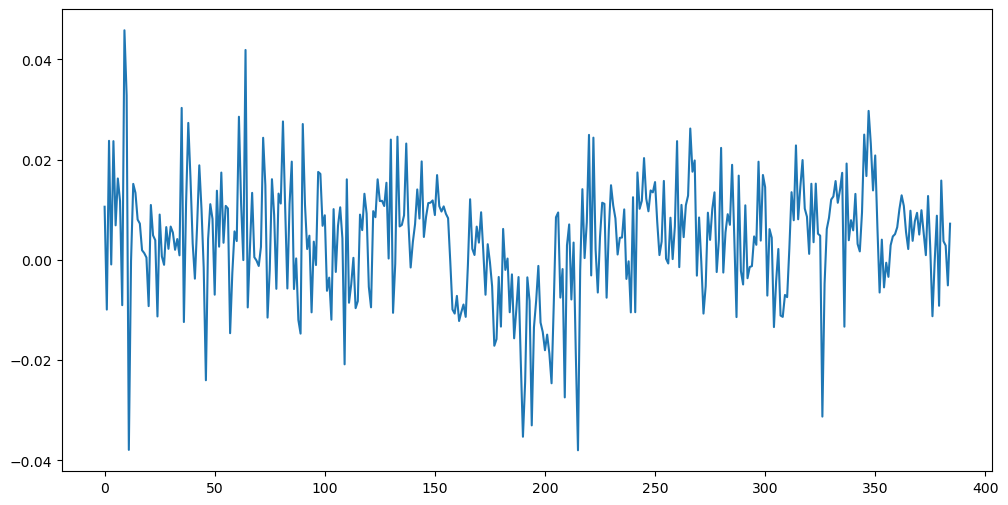

In [14]:
ydiff = np.diff(y) #this differences the data
plt.figure(figsize = (12, 6))
plt.plot(ydiff)
plt.show()

Now we look for an appropriate AR($p$) or MA($q$) model to the data. For this, let us first plot the sample ACF and PACF values. 

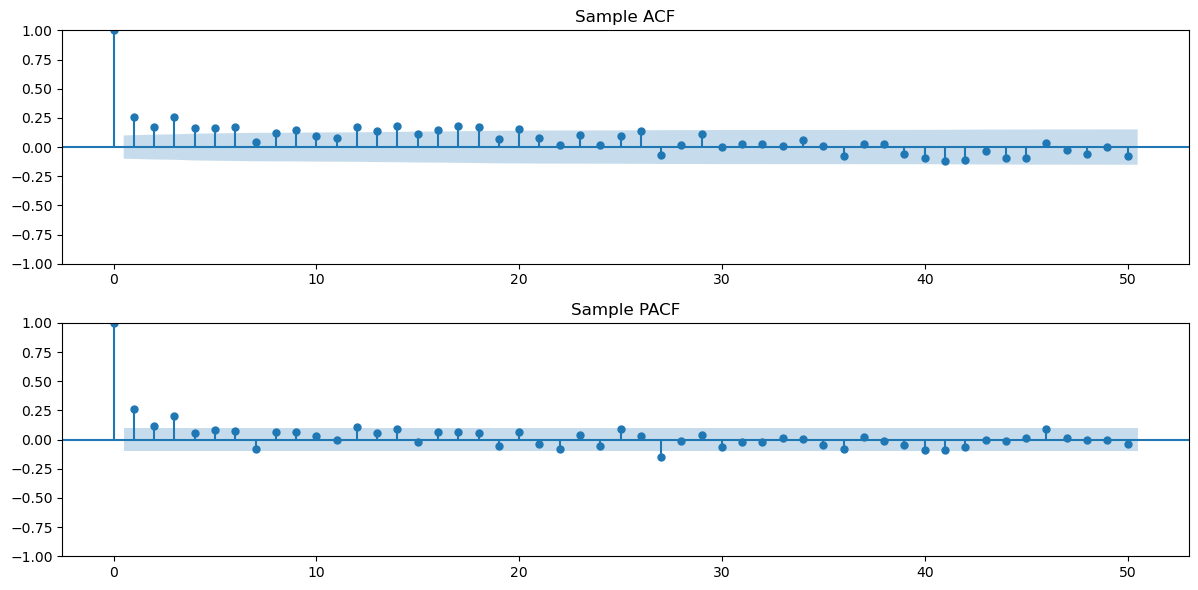

In [15]:
h_max = 50
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))
plot_acf(ydiff, lags = h_max, ax = axes[0])
axes[0].set_title("Sample ACF")
plot_pacf(ydiff, lags = h_max, ax = axes[1])
axes[1].set_title("Sample PACF")
plt.tight_layout()
plt.show()

The sample PACF appears to be negligible after lag 3. This suggests fitting an AR(3) model to the data. 

In [19]:
p = 3
armod = AutoReg(ydiff, lags = p).fit()
print(armod.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  385
Model:                     AutoReg(3)   Log Likelihood                1179.667
Method:               Conditional MLE   S.D. of innovations              0.011
Date:                Wed, 16 Apr 2025   AIC                          -2349.335
Time:                        23:36:28   BIC                          -2329.608
Sample:                             3   HQIC                         -2341.509
                                  385                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.302      0.001       0.001       0.003
y.L1           0.2148      0.050      4.309      0.000       0.117       0.313
y.L2           0.0636      0.051      1.252      0.2

From the Modulus values reported near the end of the summary table, it is clear that the fitted AR(3) model is causal and stationary. Let us use the fitted model to predict the future values of the time series. Because the model is fitted to the differenced data, we would need to convert it to the original data before makign predictions. The fitted model is: 
\begin{equation*}
    y_t - y_{t-1} = \hat{\phi}_0 + \hat{\phi}_1 \left(y_{t-1} - y_{t-2} \right) + \hat{\phi}_2 \left(y_{t-2} - y_{t-3} \right) + \hat{\phi}_3 \left(y_{t-3} - y_{t-4} \right) + \epsilon_t
\end{equation*}
which is equivalent to
\begin{equation*}
    y_t = \hat{\phi}_0 + \left(1 + \hat{\phi}_1 \right) y_{t-1} + \left(\hat{\phi}_2 - \hat{\phi}_1 \right) y_{t-2} + \left(\hat{\phi}_3 - \hat{\phi}_2 \right) y_{t-3}  - \hat{\phi}_3 y_{t-4} + \epsilon_t
\end{equation*}
This is an AR(4) model and we can predict using it in the usual way as follows. 

In [20]:
#The following are the coefficients of the above AR(4) model: 
phi_vals = np.array([armod.params[0], armod.params[1] + 1, armod.params[2] - armod.params[1], armod.params[3]-armod.params[2], -armod.params[3]])
print(phi_vals)

[ 0.00207946  1.21484133 -0.15127563  0.13781302 -0.20137871]


Below, we predict future values based on this AR(4) model. 

In [21]:
k = 100
n = len(y)
yhat = np.concatenate([y.astype(float), np.full(k, -9999)]) #extend data by k placeholder values
p = len(phi_vals)-1
for i in range(1, k+1):
    ans = phi_vals[0]
    for j in range(1, p+1):
        ans += phi_vals[j] * yhat[n+i-j-1]
    yhat[n+i-1] = ans
predvalues = yhat[n:]
print(predvalues)

[14.60592189 14.60827117 14.61255783 14.61649001 14.62015985 14.62414095
 14.62810085 14.63202315 14.63599871 14.63997905 14.64395623 14.64794376
 14.65193428 14.65592546 14.65991906 14.66391382 14.66790912 14.6719051
 14.67590149 14.67989811 14.68389496 14.68789194 14.69188902 14.69588617
 14.69988338 14.70388061 14.70787787 14.71187515 14.71587244 14.71986975
 14.72386705 14.72786436 14.73186168 14.73585899 14.73985631 14.74385363
 14.74785095 14.75184827 14.75584559 14.75984291 14.76384023 14.76783755
 14.77183488 14.7758322  14.77982952 14.78382684 14.78782416 14.79182148
 14.79581881 14.79981613 14.80381345 14.80781077 14.81180809 14.81580541
 14.81980274 14.82380006 14.82779738 14.8317947  14.83579202 14.83978934
 14.84378667 14.84778399 14.85178131 14.85577863 14.85977595 14.86377327
 14.8677706  14.87176792 14.87576524 14.87976256 14.88375988 14.8877572
 14.89175453 14.89575185 14.89974917 14.90374649 14.90774381 14.91174113
 14.91573846 14.91973578 14.9237331  14.92773042 14.9

Let us plot these predictions along with the original data. 

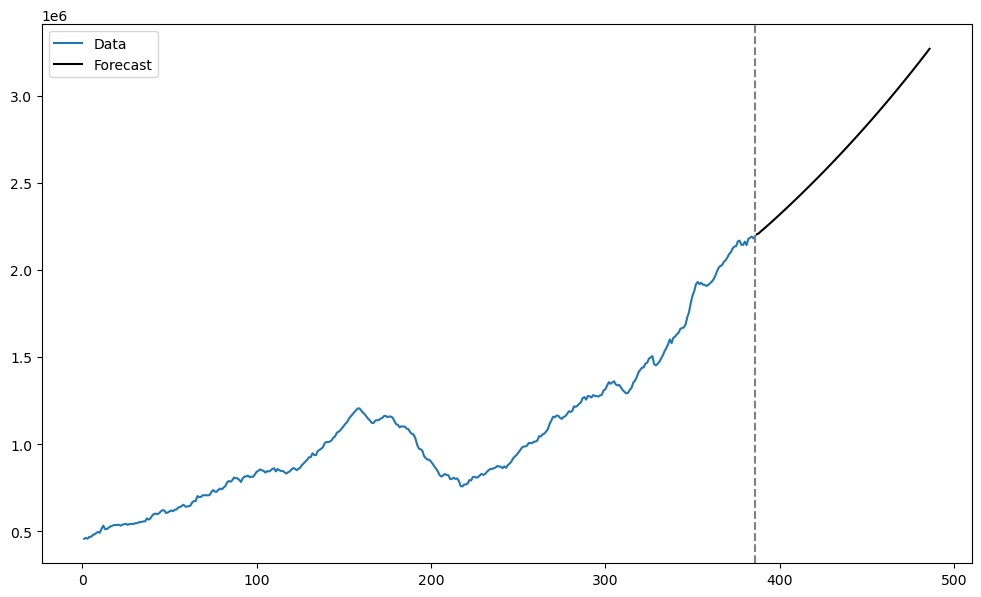

In [24]:
tme = range(1, n+1)
tme_future = range(n+1, n+k+1)
plt.figure(figsize = (12, 7))
plt.plot(tme, np.exp(y), label = 'Data')
plt.plot(tme_future, np.exp(predvalues), label = 'Forecast', color = 'black')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

### AR(3) without intercept

To illustrate a technical point, suppose that we don't want an intercept term while fitting the AR(3) model after differencing. We can do this by setting **trend = 'n'** in AutoReg as follows.

In [25]:
p = 3
armod_nointercept = AutoReg(ydiff, lags = p, trend = 'n').fit()
print(armod_nointercept.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  385
Model:                     AutoReg(3)   Log Likelihood                1174.291
Method:               Conditional MLE   S.D. of innovations              0.011
Date:                Wed, 16 Apr 2025   AIC                          -2340.582
Time:                        23:39:31   BIC                          -2324.800
Sample:                             3   HQIC                         -2334.321
                                  385                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.2497      0.049      5.052      0.000       0.153       0.347
y.L2           0.0941      0.051      1.857      0.063      -0.005       0.193
y.L3           0.2363      0.049      4.791      0.0

The above AR(3) model is also in the causal stationary regime. It can be converted to the following AR(4) model for the original (undifferenced) $y_t$: 
\begin{equation*}
   y_t = (1 + \hat{\phi}_1) y_{t-1} + (\hat{\phi}_2 - \hat{\phi}_1) y_{t-2} + (\hat{\phi}_3 - \hat{\phi}_2) y_{t-3} - \hat{\phi}_3 y_{t-4} + \epsilon_t. 
\end{equation*}

In [27]:
print(armod_nointercept.params)
phi_vals_nointercept = np.array([0, armod_nointercept.params[0] + 1, armod_nointercept.params[1] - armod_nointercept.params[0], armod_nointercept.params[2]-armod_nointercept.params[1], -armod_nointercept.params[2]])  
print(phi_vals_nointercept)

[0.24967117 0.0940715  0.2362693 ]
[ 0.          1.24967117 -0.15559968  0.1421978  -0.2362693 ]


Predictions using this AR model (which does not have an intercept) are computed as follows. 

In [28]:
yhat = np.concatenate([y.astype(float), np.full(k, -9999)]) #extend data by k placeholder values
p = len(phi_vals_nointercept)-1
for i in range(1, k+1):
    ans = phi_vals_nointercept[0]
    for j in range(1, p+1):
        ans += phi_vals_nointercept[j] * yhat[n+i-j-1]
    yhat[n+i-1] = ans
predvalues_nointercept = yhat[n:]
print(predvalues_nointercept)

[14.60403886 14.60401688 14.60590743 14.60685048 14.60725858 14.60789587
 14.60831618 14.60857749 14.60883285 14.60902049 14.6091531  14.60926419
 14.60934874 14.60941163 14.60946154 14.60949989 14.60952902 14.60955169
 14.60956915 14.60958252 14.60959286 14.60960083 14.60960695 14.60961167
 14.6096153  14.6096181  14.60962026 14.60962192 14.6096232  14.60962418
 14.60962494 14.60962553 14.60962598 14.60962632 14.60962659 14.60962679
 14.60962695 14.60962707 14.60962717 14.60962724 14.6096273  14.60962734
 14.60962737 14.6096274  14.60962742 14.60962743 14.60962744 14.60962745
 14.60962746 14.60962746 14.60962747 14.60962747 14.60962747 14.60962748
 14.60962748 14.60962748 14.60962748 14.60962748 14.60962748 14.60962748
 14.60962748 14.60962748 14.60962748 14.60962748 14.60962748 14.60962748
 14.60962748 14.60962748 14.60962748 14.60962748 14.60962748 14.60962748
 14.60962748 14.60962748 14.60962748 14.60962748 14.60962748 14.60962748
 14.60962748 14.60962748 14.60962748 14.60962748 14

Let us plot the different predictions together. 

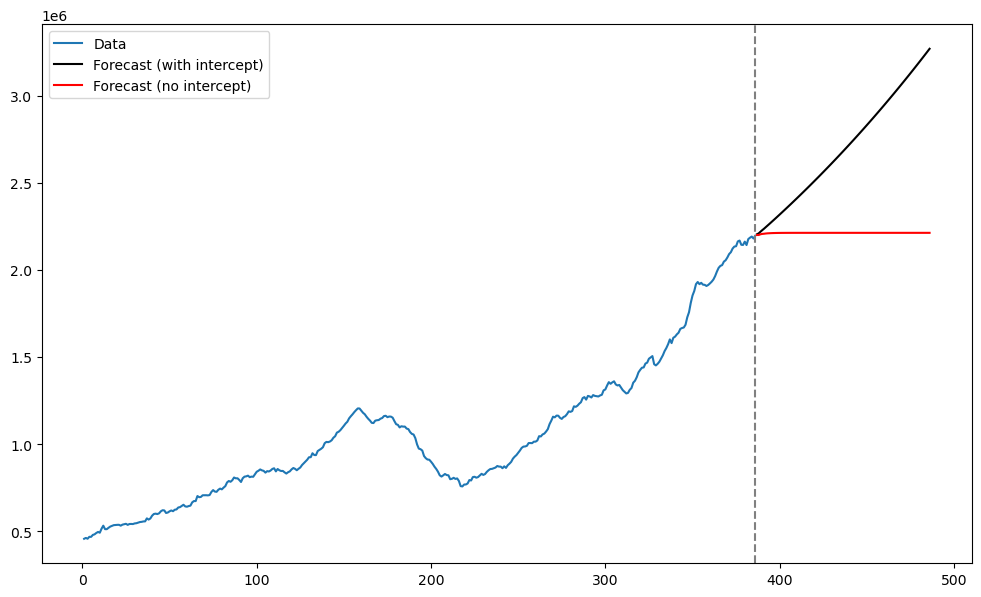

In [29]:
plt.figure(figsize = (12, 7))
plt.plot(tme, np.exp(y), label = 'Data')
plt.plot(tme_future, np.exp(predvalues), label = 'Forecast (with intercept)', color = 'black')
plt.plot(tme_future, np.exp(predvalues_nointercept), label = 'Forecast (no intercept)', color = 'red') 
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

The two predictions are quite different. The absence of the intercept term seems to make a big difference in the predictions in this example. 

### Model Fitting and Prediction using the function ARIMA

Below we fit AR and MA models (as well as ARMA models) using the function ARIMA. ARIMA models are indexed by three nonnegative integers $(p, d, q)$. $p$ denotes the AR order, $q$ denotes the MA order and d denotes the order of differencing. For example, if we want to fit the AR(3) model to the data $y_t$, then we will use ARIMA with order $(3, 0, 0)$. If we want to fit AR(3) to the **differenced** data, we will use ARIMA with order $(3, 1, 0)$. If we want to fit $MA(2)$ to twice-differenced data ($(y_t - y_{t-1}) - (y_{t-1} - y_{t-2})$), we will use ARIMA with order $(0, 2, 2)$. 

Below, we fit the AR(3) model to the differenced data $y_t - y_{t-1}$ using the ARIMA function with order $(3, 1, 0)$. Note that the ARIMA function is applied directly to the original data $y_t$ (and not to the differenced series). 

In [33]:
from statsmodels.tsa.arima.model import ARIMA
ar_arima = ARIMA(y, order = (3, 1, 0)).fit()
print(ar_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                TTLCONS   No. Observations:                  386
Model:                 ARIMA(3, 1, 0)   Log Likelihood                1181.467
Date:                Thu, 17 Apr 2025   AIC                          -2354.934
Time:                        00:02:58   BIC                          -2339.121
Sample:                             0   HQIC                         -2348.662
                                - 386                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2497      0.047      5.316      0.000       0.158       0.342
ar.L2          0.0941      0.042      2.216      0.027       0.011       0.177
ar.L3          0.2363      0.046      5.127      0.0

One thing to note is that the ARIMA function does not fit a intercept term by default when the differencing order $d \geq 1$. Below we obtain forecasts for the data using the fitted ARIMA model. The predictions outputted by the get_prediction() function directly applies to $y_t$ (there is no need to do any conversion of the predictions of the differenced series to predictions of the original series; these conversions are automatically done by the get_prediction() function).

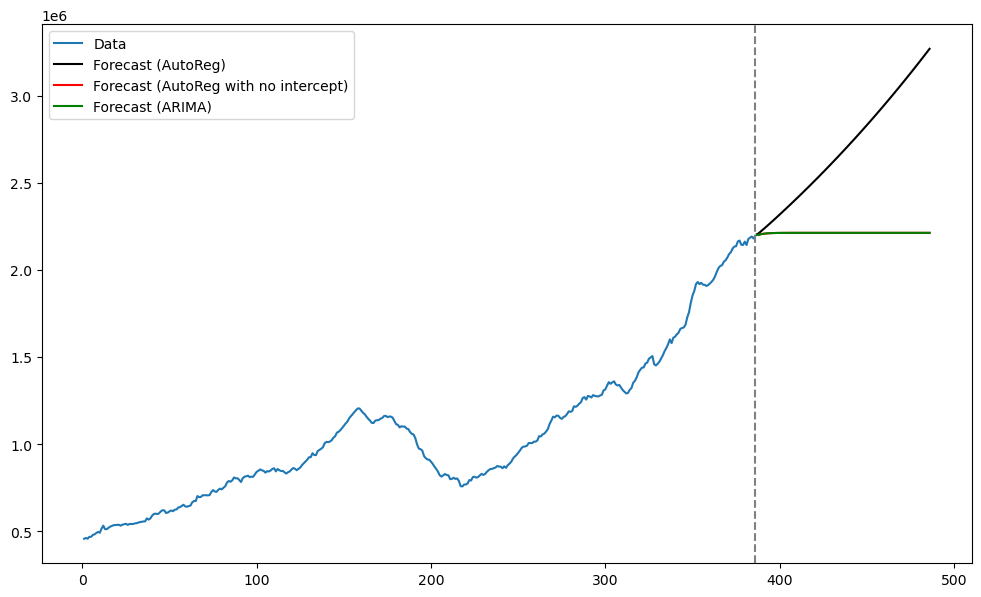

In [35]:
fcast = ar_arima.get_prediction(start = n, end = n+k-1) 
fcast_mean = fcast.predicted_mean #this gives the point predictions
plt.figure(figsize = (12, 7))
plt.plot(tme, np.exp(y), label = 'Data')
plt.plot(tme_future, np.exp(predvalues), label = 'Forecast (AutoReg)', color = 'black')
plt.plot(tme_future, np.exp(predvalues_nointercept), label = 'Forecast (AutoReg with no intercept)', color = 'red') 
plt.plot(tme_future, np.exp(fcast_mean), label = 'Forecast (ARIMA)', color = 'green')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

The predictions obtained by the ARIMA model coincide with those obtained by the AutoReg model with no intercept. 

### Double Differenced Data (ARIMA models with d = 2)

The differenced series (ydiff) plotted above might be said to have some trends. One can get rid of these by differencing the series again. 

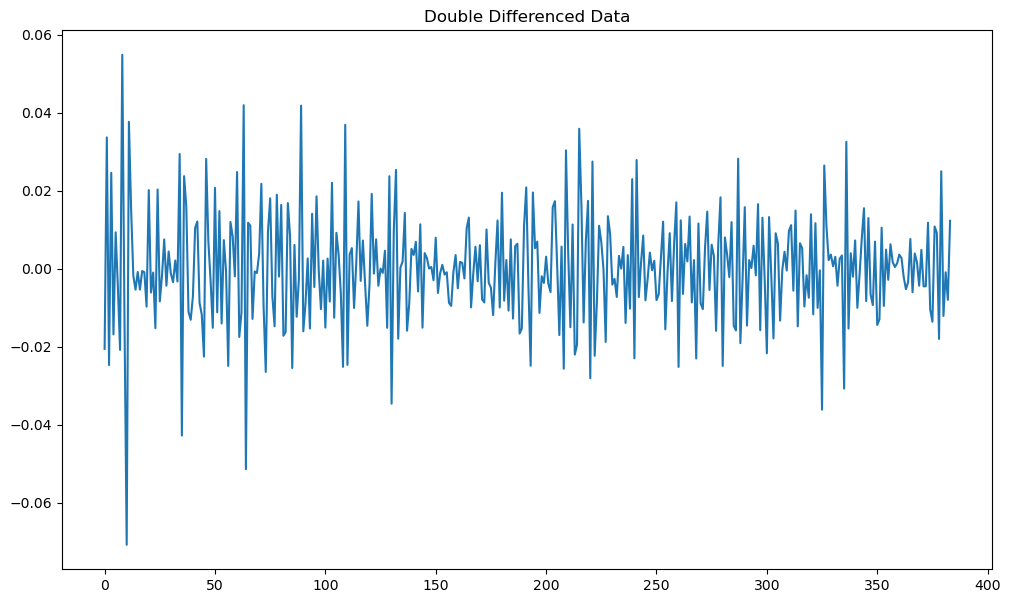

In [36]:
ydiff2 = np.diff(np.diff(y))
plt.figure(figsize = (12, 7))
plt.plot(ydiff2)
plt.title("Double Differenced Data")
plt.show()

Let us look at the sample acf and pacf of the double differenced data. 

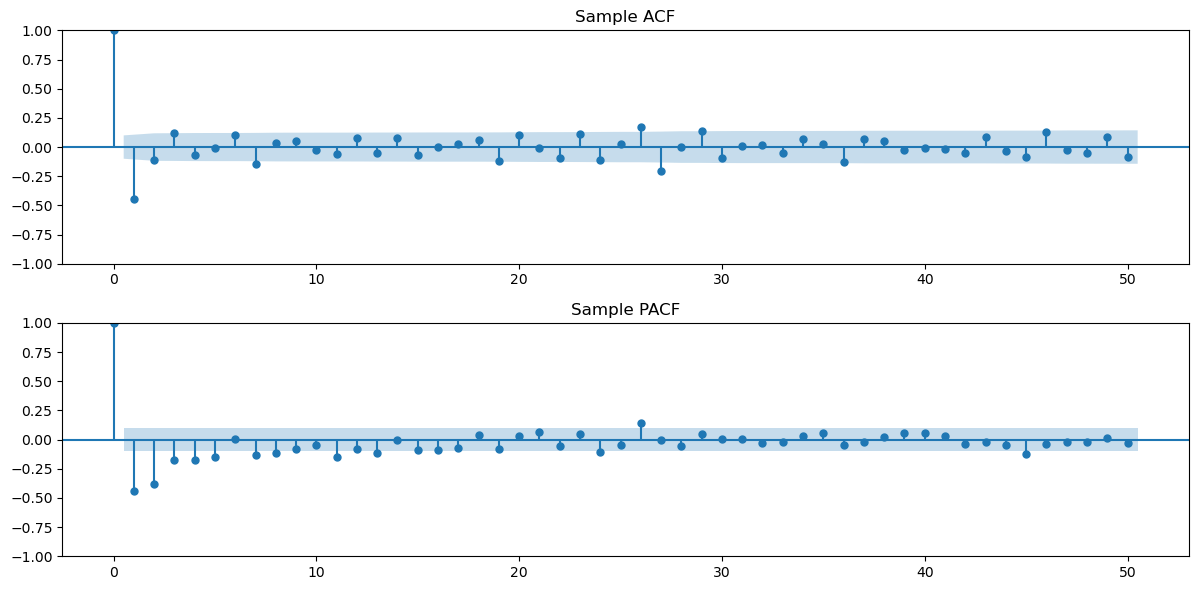

In [37]:
h_max = 50
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))
plot_acf(ydiff2, lags = h_max, ax = axes[0])
axes[0].set_title("Sample ACF")
plot_pacf(ydiff2, lags = h_max, ax = axes[1])
axes[1].set_title("Sample PACF")
plt.tight_layout()
plt.show()

From the ACF above, MA(1) is a simple model that can be used for this double-difference data. We shall fit this model. Instead of fitting the model to the double-differenced data, we can directly use ARIMA with order (0, 2, 1) to the original data. This model can then be used to obtain forecasts for the original data directly. 

In [41]:
ma_arima = ARIMA(y, order = (0, 2, 1)).fit()
print(ma_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                TTLCONS   No. Observations:                  386
Model:                 ARIMA(0, 2, 1)   Log Likelihood                1180.661
Date:                Thu, 17 Apr 2025   AIC                          -2357.321
Time:                        00:31:21   BIC                          -2349.420
Sample:                             0   HQIC                         -2354.187
                                - 386                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8810      0.025    -35.142      0.000      -0.930      -0.832
sigma2         0.0001   6.92e-06     17.993      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   1.80   Jarque-

The model that is fit here is: $y_t - 2 y_{t-1} + y_{t-2} = \epsilon_t + \theta \epsilon_{t-1}$. Note that there is no mean term $\mu$ on the right hand side. 

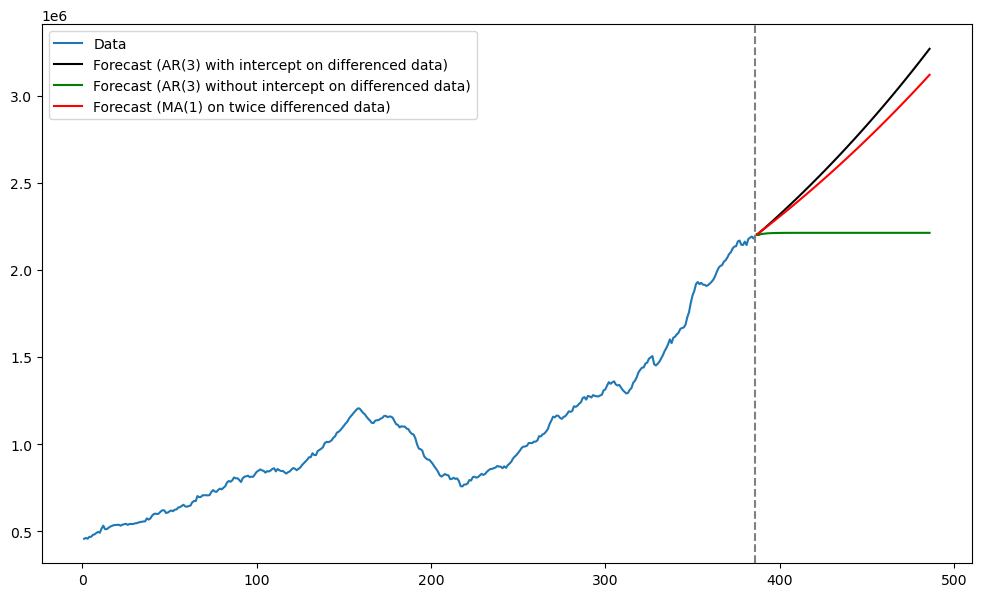

In [42]:
fcast_ma = ma_arima.get_prediction(start = n, end = n+k-1) 
fcast_mean_ma = fcast_ma.predicted_mean #this gives the point predictions
plt.figure(figsize = (12, 7))
plt.plot(tme, np.exp(y), label = 'Data')
plt.plot(tme_future, np.exp(predvalues), label = 'Forecast (AR(3) with intercept on differenced data)', color = 'black')
plt.plot(tme_future, np.exp(fcast_mean), label = 'Forecast (AR(3) without intercept on differenced data)', color = 'green')
plt.plot(tme_future, np.exp(fcast_mean_ma), label = 'Forecast (MA(1) on twice differenced data)', color = 'red')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

Next we try to search over a whole range of ARIMA models for the double differenced data using the AIC and BIC model selection criteria. Lower values of these criteria are preferable. Fitting ARMA mdoels can be tricky and the code gives warnings for some of the models. We will just ignore them. 

In [43]:
dt = ydiff2
pmax = 5
qmax = 5

aicmat = np.full((pmax + 1, qmax + 1), np.nan)
bicmat = np.full((pmax + 1, qmax + 1), np.nan)

for i in range(pmax + 1):
    for j in range(qmax + 1):
        try:
            model = ARIMA(dt, order=(i, 0, j)).fit()
            aicmat[i, j] = model.aic
            bicmat[i, j] = model.bic
        except Exception as e:
            # Some models may not converge; skip them
            print(f"ARIMA({i},0,{j}) failed: {e}")
            continue

aic_df = pd.DataFrame(aicmat, index=[f'AR({i})' for i in range(pmax+1)],
                               columns=[f'MA({j})' for j in range(qmax+1)])
bic_df = pd.DataFrame(bicmat, index=[f'AR({i})' for i in range(pmax+1)],
                               columns=[f'MA({j})' for j in range(qmax+1)])

# Best AR model (MA = 0)
best_ar_aic = np.nanargmin(aicmat[:, 0])
best_ar_bic = np.nanargmin(bicmat[:, 0])

# Best MA model (AR = 0)
best_ma_aic = np.nanargmin(aicmat[0, :])
best_ma_bic = np.nanargmin(bicmat[0, :])

# Best ARMA model overall
best_arma_aic = np.unravel_index(np.nanargmin(aicmat), aicmat.shape)
best_arma_bic = np.unravel_index(np.nanargmin(bicmat), bicmat.shape)

# Print results
print(f"Best AR model by AIC: AR({best_ar_aic})")
print(f"Best AR model by BIC: AR({best_ar_bic})")

print(f"Best MA model by AIC: MA({best_ma_aic})")
print(f"Best MA model by BIC: MA({best_ma_bic})")

print(f"Best ARMA model by AIC: ARIMA{best_arma_aic}")
print(f"Best ARMA model by BIC: ARIMA{best_arma_bic}")


/Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/aditya/mambaforge/envs/stat153spring2025/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as star

Best AR model by AIC: AR(5)
Best AR model by BIC: AR(5)
Best MA model by AIC: MA(3)
Best MA model by BIC: MA(2)
Best ARMA model by AIC: ARIMA(3, 2)
Best ARMA model by BIC: ARIMA(0, 2)


The best MA model for the double-differenced data is MA(2) (using BIC) and MA(3) (using AIC). Overall the best ARMA model for the double-differenced data is ARMA(3, 2) (AIC) and MA(2) (BIC). Below we fit the ARMA(3, 2) model to the double-differenced data (we apply it to the original data as ARIMA(3, 2, 2)). 

                               SARIMAX Results                                
Dep. Variable:                TTLCONS   No. Observations:                  386
Model:                 ARIMA(3, 2, 2)   Log Likelihood                1184.277
Date:                Thu, 17 Apr 2025   AIC                          -2356.554
Time:                        00:31:41   BIC                          -2332.850
Sample:                             0   HQIC                         -2347.152
                                - 386                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0097      0.490     -0.020      0.984      -0.970       0.951
ar.L2          0.0023      0.068      0.034      0.973      -0.130       0.135
ar.L3          0.1197      0.059      2.046      0.0

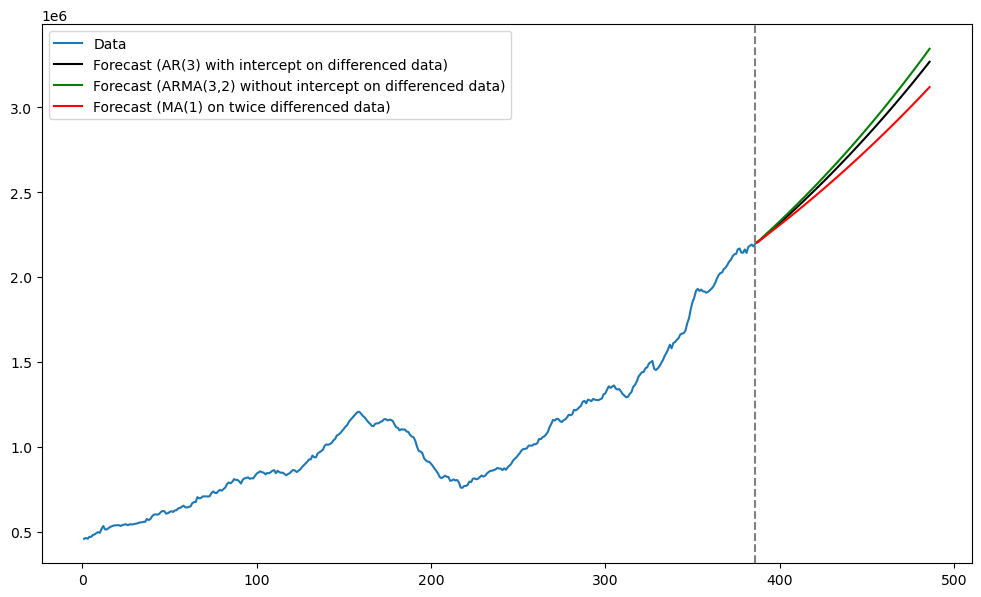

In [44]:
arma_arima = ARIMA(y, order = (3, 2, 2)).fit()
print(arma_arima.summary())
fcast_arma = arma_arima.get_prediction(start = n, end = n+k-1) 
fcast_mean_arma = fcast_arma.predicted_mean #this gives the point predictions
plt.figure(figsize = (12, 7))
plt.plot(tme, np.exp(y), label = 'Data')
plt.plot(tme_future, np.exp(predvalues), label = 'Forecast (AR(3) with intercept on differenced data)', color = 'black')
plt.plot(tme_future, np.exp(fcast_mean_arma), label = 'Forecast (ARMA(3,2) without intercept on differenced data)', color = 'green')
plt.plot(tme_future, np.exp(fcast_mean_ma), label = 'Forecast (MA(1) on twice differenced data)', color = 'red')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

It is interesting that ARIMA(3, 2, 2) and ARIMA(3, 1, 0) give nearly the same predictions. 